In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from random import uniform
from myrand import generate_TCL_ms
from iminuit import Minuit
from iminuit.cost import LeastSquares
from mix import sturges

In [3]:
def phi(x, a, b, c):
    return a + x * b + x**2 * c

## disegna l'andamento della funzione parabolica nell'intervallo 0-10

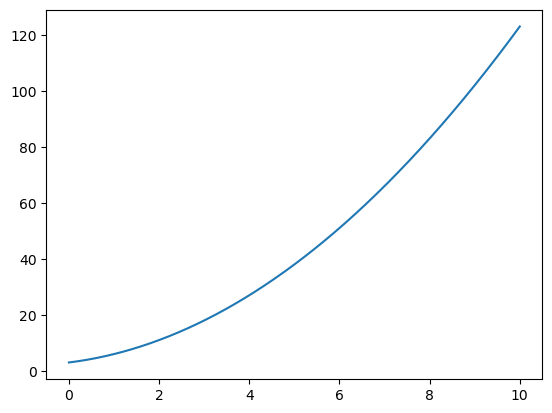

In [4]:
fig, ax = plt. subplots(nrows =1 , ncols =1)

x = np.linspace(0, 10, 1000)
a = 3
b = 2
c = 1
y = phi(x, a, b, c)

ax.plot(x, y, label = 'phi')

## GENERA 10 PUNTI UNIFORMI E ASSOCIA AD OGNUNO UNA COORDINATA y(i) = phi + e(i), dove 'e' è un errore generato con TLC gauss di media 0 e dev 10

<ErrorbarContainer object of 3 artists>

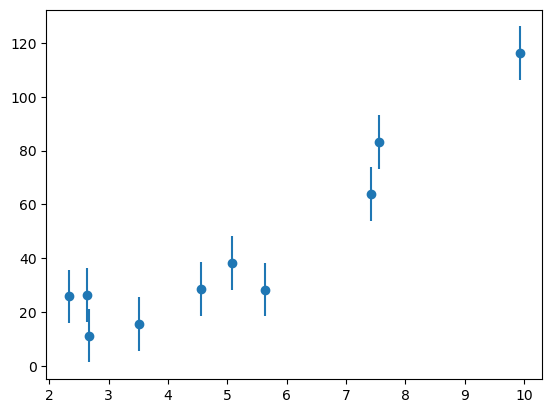

In [8]:
fig,ax = plt.subplots(nrows = 1, ncols = 1)
x_coord = np.array([uniform (0,10) for i in range (10)])
x_coord.sort()
#Genero le y tramite map 
y_coord = list(map(lambda k:sum(k), zip (phi (x_coord, a, b, c), generate_TCL_ms (0., 10, 10)))) 
sigma = 10
ax.errorbar(x_coord, y_coord, yerr = sigma, linestyle = '', marker = 'o')


## FAI UN FIT DELLA FUNZIONE

In [9]:
least_squares = LeastSquares(x_coord, y_coord, 10, phi)
fit = Minuit (least_squares, a = 1, b = 1, c = 1)
fit.migrad()
fit.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.074 (χ²/ndof = 0.9)      │              Nfcn = 71               │
│ EDM = 5.07e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    26     │    18     │            │            │         │         │       │
│ 1 │ b    │    -7     │     7     │            │            │         │         │       │
│ 2 │ c    │    1.7    │    0.6    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │     a     b     c │
├───┼───────────────────┤
│ a │   316  -120  9.38 │
│ b │  -120  47.7 -3.95 │
│ c │  9.38 -3.95 0.339 │
└───┴───────────────────┘

In [10]:
print(fit.fval) 

6.074347003740392


## FAI LA DISTRIBUZIONE DEL Q2 RIPETENDO CON TOY

In [9]:
N_toys = 1000

Q2 = []
for i in range (N_toys):
    x_coord = np.array([uniform(0,10) for i in range (10)])
    x_coord.sort()
    y_coord = list(map(lambda k:sum(k), zip(phi(x_coord, a, b, c), generate_TCL_ms(0, 10, 10))))
    least_squares = LeastSquares(x_coord, y_coord, sigma, phi)
    fit = Minuit(least_squares, a = 1, b = 1 , c = 1)
    fit.migrad()
    Q2.append(fit.fval)

## ORA FALLA CON SCARTI GENERATI UNIFORMEMENTE CON STESSA DEVIAZIONE DELLA GAUSSIANA E DISEGNA LA DISTRIBUZIONE

In [10]:
N_toys = 1000

Q2_unif = []
for i in range (N_toys):
    x_coord = np.array([uniform(0,10) for i in range (10)])
    x_coord.sort()
    y_coord = list(map(lambda k:sum(k), zip(phi (x_coord, a, b, c), [uniform(-1.732 *sigma, 1.732 *sigma) for i in range (10)])))
    #1.732 = sqrt 3. Se ho gaussiana su intervallo (-1, 1) con dev = sigma, 
    #la sua varianza è pari a quella di una distribuz. uniforme sull'intervallo (-1.732, 1.732)
    #la deviazione dell'uniforme è infatti (a-b)^2 / 12, e (2* sqrt(3))**2 = 12
    
    least_squares = LeastSquares(x_coord, y_coord, sigma, phi)
    fit = Minuit(least_squares, a = 1, b = 1 , c = 1)
    fit.migrad()
    Q2_unif.append(fit.fval)

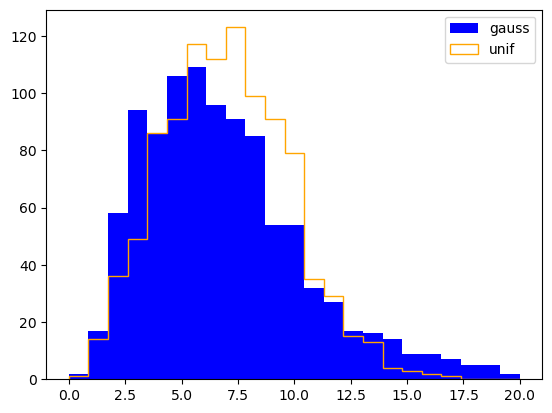

In [11]:
def sturges(N_events):
    return int(np.ceil(1 + 3.322 * np.log(N_events)))

#DISEGNO DAL DISTRIBUZIONE DEL Q^2 PER ENTRAMBE LE FUNZIONI
N_bins = sturges(len(Q2))
xMin = 0
xMax = 20
bin_edges = np.linspace(xMin, xMax, N_bins)
fig, ax = plt.subplots(nrows =1, ncols =1)
ax.hist(Q2, bins = bin_edges, color = 'blue', label = 'gauss')
ax.hist(Q2_unif, bins = bin_edges, color = 'orange', label = 'unif', histtype = 'step')
ax.legend()
    

## USANDO LA DISTRIBUZIONE Q2, DETERMINA LA SOGLIA OLTRE LA QUALE RIGETTARE IL RISULTATO DEL FIT (P-VALUE > 0.1)

In [12]:
from math import floor
N_treshold = floor(0.9 * N_toys) #IMPOSTO LA SOGLIA
Q2_unif.sort() #RIORDINO DI Q2
print(f'soglia 90%: {Q2_unif[N_treshold]}') #STAMPO IL VALORE DI SOGLIA

soglia 90%: 10.502837487309492


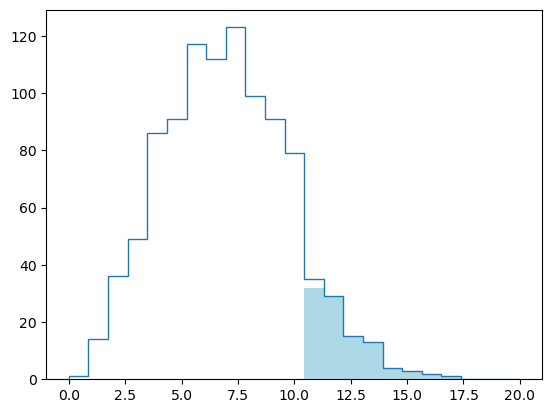

In [14]:
Q2_unif_rigetto = [val for val in Q2_unif if val > Q2_unif[N_treshold]] #RIGETTO I VALORI > soglia

fig,ax = plt.subplots(nrows = 1, ncols = 1)
ax.hist(Q2_unif, bin_edges, histtype = 'step');
ax.hist(Q2_unif_rigetto, bin_edges, color = 'lightblue');